## Fed-batch plotter
Notebook for plotting fed-batch data obtained from mathematica.



### Preliminaries

In [1]:
## Load Libraries and display versions
import os
import glob

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import label

import matplotlib
print("Matplotlib version:", matplotlib.__version__)
import pandas as pd
print("Pandas version:", pd.__version__)
import numpy as np
print("NumPy version:", np.__version__)
import scipy
print("SciPy version:", scipy.__version__)

Matplotlib version: 3.9.1
Pandas version: 2.2.2
NumPy version: 1.26.4
SciPy version: 1.13.1


In [2]:
# Set up global variables

# color codes
cb_blue = '#0072B2'
cb_orange = '#D55E00'
cb_green = '#009E73'

# input directory
indir=os.getcwd()+"/../data/"

# output directory for figures
outdir = '../figures'
os.makedirs(outdir, exist_ok=True)  

# mapping between file names and x0_values (i.e. initial biomass concentrations)
file_to_x_value_map = {
    'x01': 0.001,
    'x02': 0.0022,
    'x03': 0.0047,
    'x04': 0.01,
    'x05': 0.022,
    'x06': 0.047,
    'x07': 0.1
}
x_keys=[key for key in file_to_x_value_map.keys()]
x_values=[key for key in file_to_x_value_map.values()]
num_datasets=len(file_to_x_value_map.keys())

# production types
productiontypes=['No production ($\pi_0,\pi_1=0$)',
                 'Growth coupled production  ($\pi_0=0, \pi_1>0$)',
                 'Growth decoupled production  ($\pi_0>0, \pi_1=0$)',
                 'Growth coupled and -decoupled production ($\pi_0,\pi_1>0$)']

### Load in Data

In [3]:
def read_all_csvs_in_directory(directory_path):
    """
    Reads all CSV files in a directory into separate pandas DataFrames 
        without headers, and names them based on the filenames.

    Parameters:
    directory_path (str): The path to the directory containing the CSV files.

    Returns:
    dict: A dictionary where keys are filenames (without extension) 
        and values are corresponding DataFrames.
    """
    dataframes = {}
    
    try:
        # Use glob to find all CSV files in the directory
        csv_files = glob.glob(os.path.join(directory_path, "*.csv"))
        
        if not csv_files:
            print(f"No CSV files found in the directory: {directory_path}")
            return dataframes
        
        for file_path in csv_files:
            try:
                # use filename without extension as key
                filename = os.path.splitext(os.path.basename(file_path))[0]
                
                # Read CSV file into DataFrame without header
                dataframe = pd.read_csv(file_path, header=None)
                
                # Store DataFrame in dictionary with filename as the key
                dataframes[filename] = dataframe
                
            except FileNotFoundError:
                print(f"File at {file_path} was not found.")
            except pd.errors.EmptyDataError:
                print(f"No data: File {file_path} is empty.")
            except pd.errors.ParserError:
                print(f"Parse error: File {file_path} could not be parsed.")
            except Exception as e:
                print(f"An error occurred with File {file_path}: {e}")
    
    except Exception as e:
        print(
            f"An error occurred while reading the directory {directory_path}: {e}"
              )
    
    return dataframes

# read in data
all_csvs=read_all_csvs_in_directory(indir)

### Plotting
#### Volume and Feed

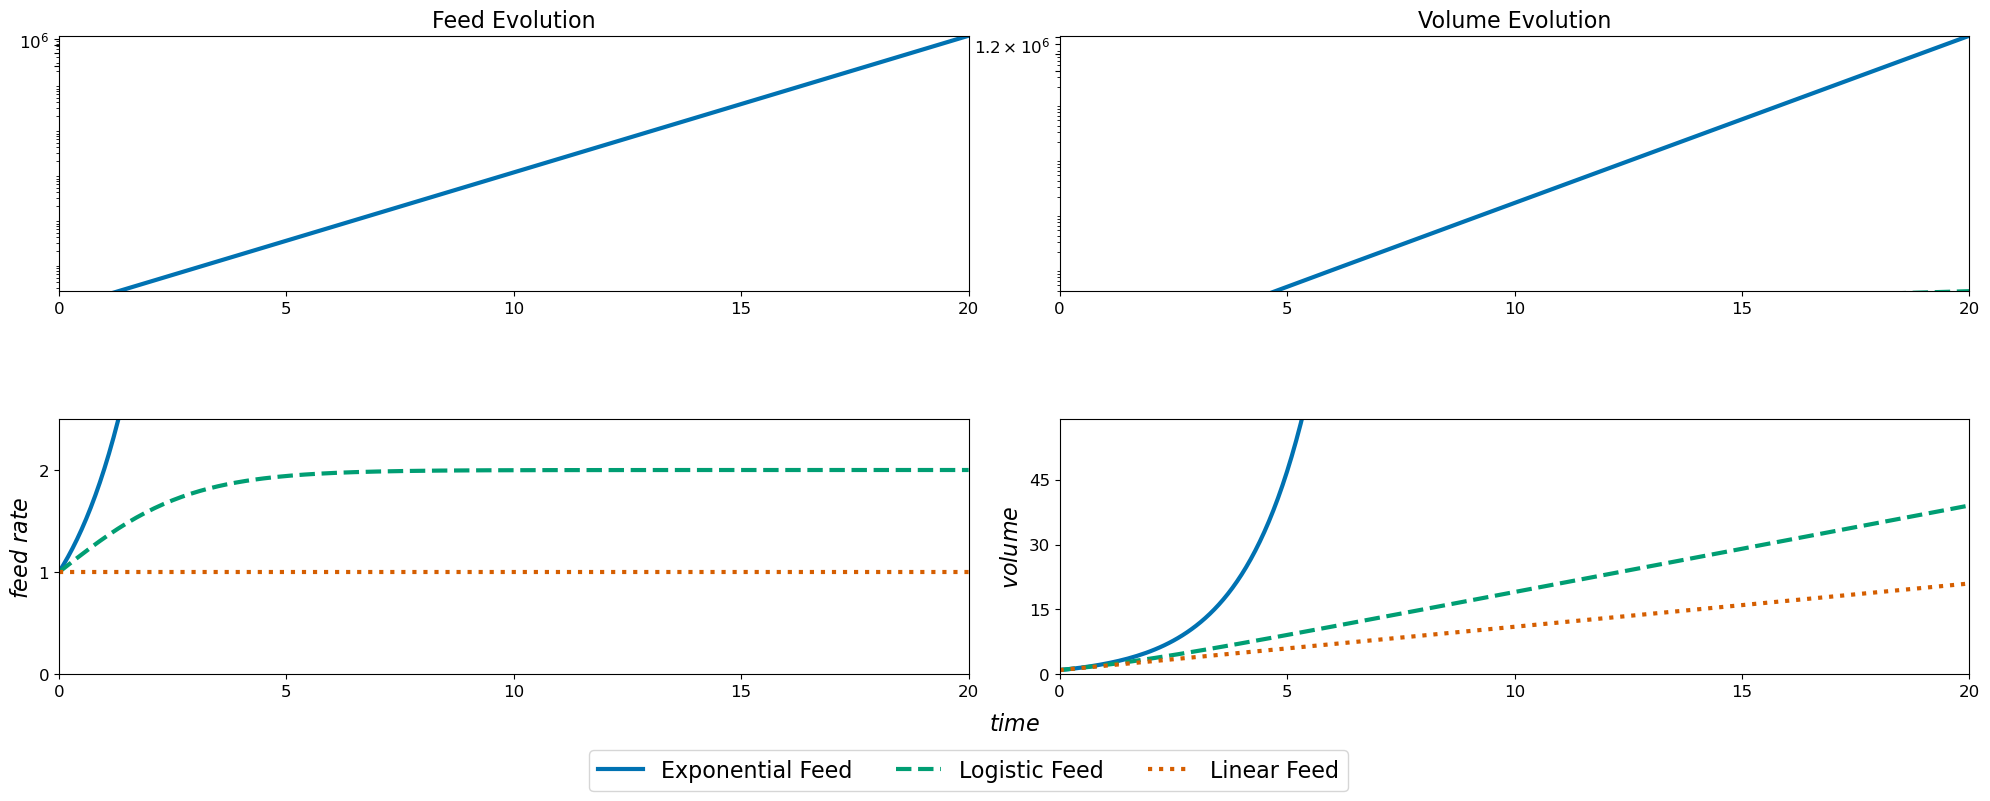

In [4]:
def plot_volume_evolution(Vol,Feed,filename):
    # Create figure
    fig, axs = plt.subplots(2,2,figsize=(20, 8))  # Define figure and axes
    axs=axs.ravel()
    feeds = {}
    feeds['exp'] = {'name':"Exponential Feed",'index':2, 
                    'color':cb_blue, 'linetype':'-'}
    feeds['log'] = {'name':"Logistic Feed",'index':1, 
                    'color':cb_green, 'linetype':'--'}
    feeds['lin'] = {'name':"Linear Feed",'index':3, 
                    'color':cb_orange, 'linetype':':'}
    # Plot each feed scenario with customized lines
    for i,nombre in enumerate(feeds):
        axs[0].plot(Feed[0], Feed[feeds[nombre]['index']],
                    feeds[nombre]['linetype'],linewidth=3, 
                    color=feeds[nombre]['color'], label=feeds[nombre]['name'])
        axs[1].plot(Vol[0], Vol[feeds[nombre]['index']], 
                    feeds[nombre]['linetype'], linewidth=3, 
                    color=feeds[nombre]['color'], label=feeds[nombre]['name'])
        axs[2].plot(Feed[0], Feed[feeds[nombre]['index']],
                    feeds[nombre]['linetype'],linewidth=3, 
                    color=feeds[nombre]['color'], label=feeds[nombre]['name'])
        axs[3].plot(Vol[0], Vol[feeds[nombre]['index']], 
                    feeds[nombre]['linetype'], linewidth=3, 
                    color=feeds[nombre]['color'], label=feeds[nombre]['name'])
        
    # Set limits for x and y axis based on Vol/Feed data
    for i,j in enumerate(axs):
        if i==0:
            axs[i].set_title('Feed Evolution',fontsize=16)
            axs[i].set_xlim(Feed[0].min(), Feed[0].max())
            axs[i].set_ylim(Feed[1].max()+0.5, Feed[2].max())
            axs[i].set_yscale('log')
        elif i==1:
            axs[i].set_title('Volume Evolution',fontsize=16)
            axs[i].set_xlim(Vol[0].min(), Vol[0].max())
            axs[i].set_ylim(Vol[1].max(), Vol[2].max())
            axs[i].set_yscale('log')
        elif i==2:
            axs[i].set_ylabel(r'$feed$ $rate$', fontsize=16)
            axs[i].set_xlim(Feed[0].min(), Feed[0].max())
            axs[i].set_ylim(0, Feed[1].max()+0.5)
        elif i==3:
            axs[i].set_ylabel(r'$volume$', fontsize=16)
            axs[i].set_xlim(Vol[0].min(), Vol[0].max())
            axs[i].set_ylim(0, Vol[1].max()+20)
        axs[i].tick_params(axis='both', which='major', labelsize=12)
        axs[i].xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))
        axs[i].yaxis.set_major_locator(MaxNLocator(integer=True,nbins=5))
        
    # One legend and x-axis label for both plots
    axs[2].legend(loc='lower center', bbox_to_anchor=(1, -0.5), ncol=3, fontsize=16)
    fig.text(0.51, 0.08, '$time$', fontsize=16, ha='center')

    plt.tight_layout(rect=[0, 0, 1, 1])  # Gives more room for legend and title
    plt.subplots_adjust(bottom=0.15, wspace=0.1, hspace=0.5)
    output_file = os.path.join(outdir, filename)  # Define output file path
    #plt.savefig(output_file)
    plt.show()
    # Plot and save the figure

plot_volume_evolution(all_csvs['Vcombined'],all_csvs['Fcombined'], 'Vol.png')

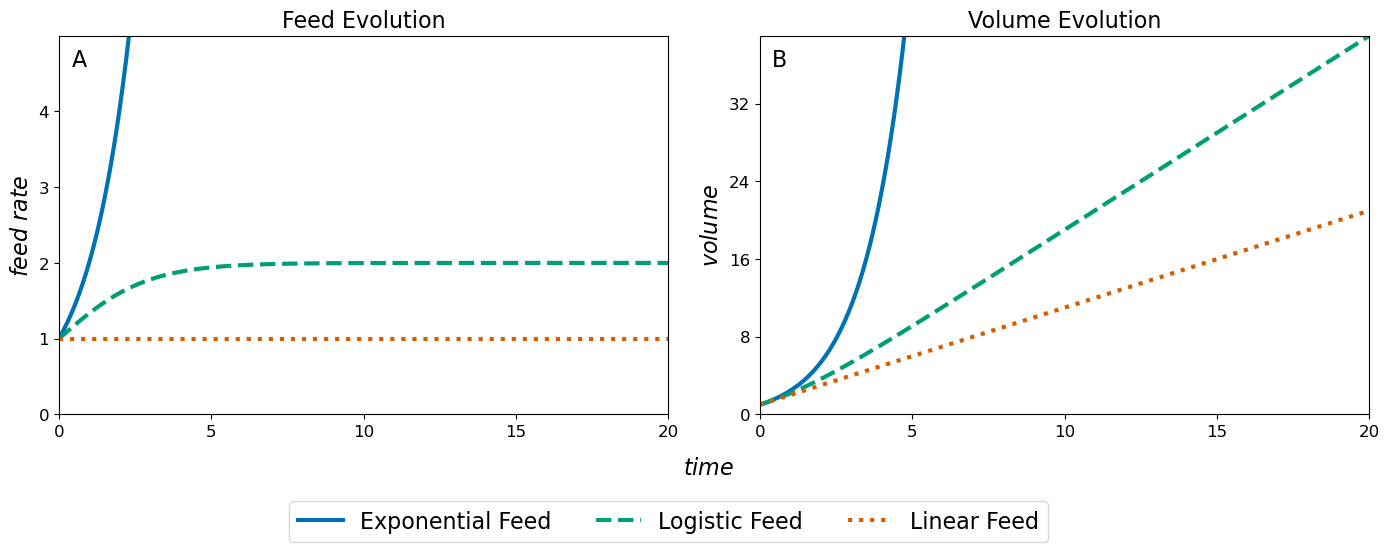

In [6]:
def plot_volume_evolution(Vol,Feed,filename):
    # Create figure
    fig, axs = plt.subplots(1,2,figsize=(14, 6))  # Define figure and axes
    axs=axs.ravel()
    feeds = {}
    feeds['exp'] = {'name':"Exponential Feed",'index':2, 
                    'color':cb_blue, 'linetype':'-'}
    feeds['log'] = {'name':"Logistic Feed",'index':1, 
                    'color':cb_green, 'linetype':'--'}
    feeds['lin'] = {'name':"Linear Feed",'index':3, 
                    'color':cb_orange, 'linetype':':'}
    # Plot each feed scenario with customized lines
    for i,nombre in enumerate(feeds):
        axs[0].plot(Feed[0], Feed[feeds[nombre]['index']],
                    feeds[nombre]['linetype'],linewidth=3, 
                    color=feeds[nombre]['color'], label=feeds[nombre]['name'])
        axs[1].plot(Vol[0], Vol[feeds[nombre]['index']], 
                    feeds[nombre]['linetype'], linewidth=3, 
                    color=feeds[nombre]['color'], label=feeds[nombre]['name'])
    # Set limits for x and y axis based on Vol/Feed data
    for i,j in enumerate(axs):
        if i==0:
            axs[i].set_ylabel(r'$feed$ $rate$', fontsize=16)
            axs[i].set_title('Feed Evolution',fontsize=16)
            axs[i].set_xlim(Feed[0].min(), Feed[0].max())
            axs[i].set_ylim(0, Feed[1].max()+3)
        elif i==1:
            axs[i].set_ylabel(r'$volume$', fontsize=16)
            axs[i].set_title('Volume Evolution',fontsize=16)
            axs[i].set_xlim(Vol[0].min(), Vol[0].max())
            axs[i].set_ylim(0, Vol[1].max())
        axs[i].tick_params(axis='both', which='major', labelsize=12)
        axs[i].xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))
        axs[i].yaxis.set_major_locator(MaxNLocator(integer=True,nbins=5))
        
    # One legend and x-axis label for both plots
    axs[0].legend(loc='upper center', bbox_to_anchor=(1, -0.2), ncol=3, fontsize=16)
    fig.text(0.51, 0.2, '$time$', fontsize=16, ha='center')
    fig.text(0.06, 0.88, 'A', fontsize=16, ha='center')
    fig.text(0.56, 0.88, 'B', fontsize=16, ha='center')
    plt.tight_layout(rect=[0, 0, 1, 1])  # Gives more room for legend and title
    plt.subplots_adjust(bottom=0.3, wspace=0.15, hspace=0.5)
    output_file = os.path.join(outdir, filename)  # Define output file path
    plt.savefig(output_file)
    #plt.show()
    # Plot and save the figure

plot_volume_evolution(all_csvs['Vcombined'],all_csvs['Fcombined'], 'Vol.png')

In [25]:
def plot_volume_evolution(Vol):
    """
    Plots the volume evolution over time for different feed scenarios.

    Parameters:
    - Vol: A dataframe containing time and volume data 
        for different feed scenarios.
    """
    fig, ax0 = plt.subplots(figsize=(12, 8))
    line_styles = ['--', '-', ':']
    colors = [cb_green, cb_blue, cb_orange]
    labels = ['Logistic Feed', 'Exponential Feed', 'Constant Feed']

    # iterate over feed rates and plot them
    for i in range(0,3):
        ax0.plot(Vol[0], Vol[i+1],line_styles[i], linewidth=3,
                color=colors[i], label=labels[i])

    # Set limits for x and y axis based on Vol data
    ax0.set_xlim(Vol[0].min(), Vol[0].max())
    ax0.set_ylim(0, Vol[1].max())

    ax0.set_xlabel(r'$time$', fontsize=16)
    ax0.set_ylabel(r'$volume$', fontsize=16)
    ax0.tick_params(axis='both', which='major', labelsize=12)
    ax0.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))
    ax0.yaxis.set_major_locator(MaxNLocator(integer=True,nbins=5))

    ax0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
               ncol=3, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0) 
    output_file = os.path.join(outdir, 'Vol.png')
    plt.savefig(output_file)
    # plt.show()
    plt.close()
    
## Function call: Vcombined contains all volume data
plot_volume_evolution(all_csvs['Vcombined'])

end_time = all_csvs['Vcombined'][0][200]
logistic_volume = all_csvs['Vcombined'][1][200]
exponential_volume = all_csvs['Vcombined'][2][48]
constant_volume = all_csvs['Vcombined'][3][200]

print(f"End Time: {end_time:.2f}\n"
      f"Volume at End Time (Logistic Feed): {logistic_volume:.2f}\n"
      f"Volume at 48 Time Units (Exp. Feed): {exponential_volume:.2f}\n"
      f"Volume at End Time (Constant Feed): {constant_volume:.2f}")

End Time: 20.00
Volume at End Time (Logistic Feed): 39.02
Volume at 48 Time Units (Exp. Feed): 40.70
Volume at End Time (Constant Feed): 21.00


### Biomass and Product Concentration

#### Prepare concentration data

In [5]:
def prepare_concentration_data(data):
    """
    Prepares concentration data from given filenames.

    Parameters:
    - data: A dictionary where keys are filenames 
        (without extension) and values are corresponding DataFrames.

    Returns:
    - concentrations: A dictionary with concentration data organized 
        by feed type prefixes (xlog, xexp, xlin, plog, pexp, plin)

    """
    # Initialize empty dictionaries to store concentration data by x_values
    concentrations = {
        'xlog': {},
        'xexp': {},
        'xlin': {},
        'plog': {},
        'pexp': {},
        'plin': {}
    }
    valid_prefixes = {'xlog', 'xexp', 'xlin', 'plog', 'pexp', 'plin'}

    # Map filenames to x_values
    for key, filename in data.items():
        # Split the filename to extract the x0 part
        parts = key.split('_')
        prefix = parts[0]
        # Check if the prefix is one of the valid prefixes
        if prefix in valid_prefixes:
            x_suffix = parts[1]
            concentrations[prefix][x_suffix] = key 
    return concentrations

concentrations=prepare_concentration_data(all_csvs)


#### Plot for Each Production Strategy and Initial Biomass Level

In [6]:
def plot_concentration(xlog,xexp,xlin,plog,pexp,plin,xval,p,prodtype):
    """
    Plots biomass and product concentrations over time for various feed types.

    Parameters:
    - xlog: biomass data for Logistic Feed
    - xexp: biomass data for Exponential Feed
    - xlin: biomass data for Constant Feed
    - plog: product data for Logistic Feed
    - pexp: product data for Exponential Feed
    - plin: product data for Constant Feed
    - xval: initial biomass concentration.
    - p: Index of the production type.
    - prodtype: Name of the production type for the title.
    """
    fig, axs = plt.subplots(1, 2, figsize=(14,6))
    # Left Plot
    axs[0].plot(xexp[0], xexp[p], linewidth=2.5, 
                color=cb_blue, label='Exponential Feed')
    axs[0].plot(xlog[0], xlog[p], '--', linewidth=2.5, 
                color=cb_green, label='Logistic Feed')
    axs[0].plot(xlin[0], xlin[p], ':', linewidth=2.5, 
                color=cb_orange, label='Constant Feed')
    # Right Plot
    axs[1].plot(pexp[0], pexp[p], linewidth=2.5, 
                color=cb_blue, label='Exponential Feed')
    axs[1].plot(plog[0], plog[p], '--', linewidth=2.5, 
                color=cb_green, label='Logistic Feed')
    axs[1].plot(plin[0], plin[p], ':', linewidth=2.5, 
                color=cb_orange, label='Constant Feed')

    def configure_axis(ax, y_label, ylim):
        '''
        Helper function for axis configuration
        Parameters: ax, label of y-axis, limit on y-axis
        '''
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))
        ax.yaxis.set_major_locator(MaxNLocator(integer=False, nbins=5))
        ax.set_xlim(0, 20)
        ax.set_ylim(ylim)
        ax.set_ylabel(y_label, fontsize=16)
    configure_axis(axs[0], r'$Biomass$ $x$', (0, 1.05))
    configure_axis(axs[1], r'$Product$  $p$', (0, 70))
    # Get handles from the first subplot
    handles, labels = axs[0].get_legend_handles_labels()  
    fig.legend(handles, labels, loc='lower center', 
               bbox_to_anchor=(0.5, 0.005), ncol=3, fontsize=16) 
    # Single x-axis label at the bottom
    fig.text(0.52, 0.11, '$time$', fontsize=16, ha='center')
    # Add A and B panel labeling
    fig.text(0.08, 0.85, 'A', fontsize=16, ha='center')
    fig.text(0.57, 0.85, 'B', fontsize=16, ha='center')
    fig.suptitle(f'{prodtype}',fontsize=18)
    output_file = os.path.join(outdir, f'x_p_combined_nprod{str(p)}_{str(xval)}') 
    plt.subplots_adjust(bottom=0.15, wspace=0.3, hspace=0.3) 
    plt.tight_layout(rect=[0, 0.15, 1, 1]) 
    plt.savefig(output_file,bbox_inches='tight')
    #plt.show()
    plt.close()

# Function Call   
for p, prodtype in enumerate(productiontypes, start=1):
    for xnum, xval in enumerate(file_to_x_value_map.keys(), start=1):
        file_dict = {key: all_csvs[concentrations[key].get(xval)] for key in concentrations.keys()}
        plot_concentration(
            file_dict['xlog'], 
            file_dict['xexp'], 
            file_dict['xlin'], 
            file_dict['plog'], 
            file_dict['pexp'], 
            file_dict['plin'], 
            xval,
            p,
            prodtype
            )

#### Plot biomass and product with all production types and initial biomass concentrations

In [7]:
def plot_concentration_allin1(data, conc_keys, plot_type, production_types):
    """
    Plots concentration data for 4 production types 
        in a 2x2 grid of subplots.

    Parameters:
    - data: Dictionary containing concentration data 
        (x_values mapped to corresponding concentrations).
    - conc_keys: Dictionary mapping feed types to their concentration keys.
    - plot_type: Type of plot ('biomass' or 'product').
    - production_types: List of production types to be plotted
    """
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    axs = axs.ravel()
    colors = {'Logistic Feed': cb_green, 
              'Exponential Feed': cb_blue,
              'Constant Feed': cb_orange}
    line_style={'Logistic Feed': '--', 
                'Exponential Feed': '-', 
                'Constant Feed':':'}
    # Define limits for different plot types
    y_limits = {'biomass': (0, 1.05), 'product': (0, 70)}
    # Loop through production types and concentration values
    for i, prod_type in enumerate(production_types):    
        # Set titles for each subplot
        axs[i].set_title(prod_type, fontsize=14)
        # Set limits
        axs[i].set_xlim(0, 20)
        # Set y-limits based on plot type
        axs[i].set_ylim(*y_limits[plot_type])  
        # Hide ticks/numbers based on subplot position
        if i in [0, 1]:  # Top row
            axs[i].set_xticklabels([])
        if i in [1,3]:  # right column
            axs[i].set_yticklabels([]) 
        axs[i].xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4)) 
        axs[i].yaxis.set_major_locator(MaxNLocator(integer=False,nbins=5)) 
        for feed_type, conc_key in conc_keys.items():
            for j, x_val in enumerate(file_to_x_value_map.keys()):
                axs[i].plot(data[conc_key[x_val]][0], data[conc_key[x_val]][i + 1], line_style[feed_type],
                                color=colors[feed_type], linewidth=1, 
                                label=f'{feed_type}'if j == 0 else "")  
                                # Show label only once
    # Put some labels
    if plot_type=='biomass':
        fig.text(0.06, 0.54, '$Biomass$ $x$', fontsize=16, 
                 va='center', rotation='vertical')
        fig.text(0.13, 0.915, 'A', fontsize=16, ha='center')
        fig.text(0.575, 0.915, 'B', fontsize=16, ha='center')
        fig.text(0.13, 0.485, 'C', fontsize=16, ha='center')
        fig.text(0.575, 0.485, 'D', fontsize=16, ha='center')
    else:
        fig.text(0.06, 0.54, '$Product$ $p$', fontsize=16, 
                 va='center', rotation='vertical')
        fig.text(0.12, 0.915, 'A', fontsize=16, ha='center')
        fig.text(0.57, 0.915, 'B', fontsize=16, ha='center')
        fig.text(0.12, 0.485, 'C', fontsize=16, ha='center')
        fig.text(0.57, 0.485, 'D', fontsize=16, ha='center')
    fig.text(0.548, 0.07, '$time$', fontsize=16, ha='center')
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.545, -0.001), ncol=7, fontsize=14)

    output_file = os.path.join(outdir, f'titer_{plot_type}_allin1.png')
    plt.tight_layout(pad=0.5, rect=[0.08, 0.1, 1, 0.98])  
    plt.savefig(output_file, bbox_inches='tight')
    plt.close(fig)

# Define the dictionary of concentration data for both biomass and product
biomass_conc_keys = {
    'Logistic Feed': concentrations['xlog'],
    'Exponential Feed': concentrations['xexp'],
    'Constant Feed': concentrations['xlin']
}
product_conc_keys = {
    'Logistic Feed': concentrations['plog'],
    'Exponential Feed': concentrations['pexp'],
    'Constant Feed': concentrations['plin']
}

# Function calls for biomass and product
plot_concentration_allin1(
    all_csvs,             
    biomass_conc_keys,             
    'biomass',           
    productiontypes,      
)
plot_concentration_allin1(
    all_csvs,              
    product_conc_keys,
    'product',
    productiontypes,
)



### Yield

#### Prepare Yield data

In [8]:
def prepare_yield_data(data):
    """
    Extracts yield data from a dataset.

    Organizes yield data into a dictionary based on prefixes: 
    'Ylog', 'Yexp', and 'Ylin', and maps them to their corresponding x_values.

    Parameters:
    - data (dict): A dictionary with filenames as keys and df as values

    Returns:
    - dict: A nested dictionary with structure:
            {'Ylog': {x_value: key, ...}, 
             'Yexp': {x_value: key, ...}, 
             'Ylin': {x_value: key, ...}}
    """
    # Initialize dictionary
    yields = {
        'Ylog': {},
        'Yexp': {},
        'Ylin': {}
    }
    valid_prefixes = {'Ylog', 'Yexp', 'Ylin'}

    # map filenames to x_values
    for key, filename in data.items():
        # Split the filename to extract the x0 part
        parts = key.split('_')
        prefix = parts[0]
        # Check if the prefix is one of the valid prefixes
        if prefix in valid_prefixes:
            x_suffix = parts[1]
            yields[prefix][x_suffix] = key 
    return yields

yields_keys= prepare_yield_data(all_csvs)

#### Plot yield for distinct production rates

In [9]:
def plot_yield(data, Ylog, Yexp, Ylin, productiontypes):
    """
    Plots yield data for different production types (2x2)
        across various biomass concentrations.

    Parameters:
    - data (dict): The data containing yield values.
    - Ylog (dict): Yield data for logistic feed.
    - Yexp (dict): Yield data for exponential feed.
    - Ylin (dict): Yield data for constant feed.
    - productiontypes (list): List of production types to plot.
    """
    # iterate over x values
    for xval, xstr in enumerate(file_to_x_value_map.keys()):
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))
        axs = axs.ravel()
        # iterate over production types
        for pval, prodtype in enumerate(productiontypes):
            ax = axs[pval]  
            ax.plot(data[Ylog[xstr]][0], data[Ylog[xstr]][pval + 1], '--', 
                    linewidth=2.5, color=cb_green, label='Logistic Feed')
            ax.plot(data[Yexp[xstr]][0], data[Yexp[xstr]][pval + 1], '-', 
                    linewidth=2.5, color=cb_blue, label='Exponential Feed')
            ax.plot(data[Ylin[xstr]][0], data[Ylin[xstr]][pval + 1], ':', 
                    linewidth=2.5, color=cb_orange, label='Constant Feed')

            # Set limits, labels, and title for each subplot
            ax.set_xlim(0, 20)
            ax.set_ylim(0, 9.5)
            ax.tick_params(axis='both', which='major', labelsize=10)
            ax.set_title(prodtype, fontsize=12)
            ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))  
            ax.yaxis.set_major_locator(MaxNLocator(nbins=4))  
            # hide tick labels
            if pval in [0, 1]: # upper row  
                axs[pval].set_xticklabels([])
            if pval in [1, 3]: # right column
                axs[pval].set_yticklabels([])
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', 
                   bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=14)
        fig.text(0.06, 0.55, '$Yield$', fontsize=16, va='center', rotation='vertical')
        fig.text(0.545, 0.03, '$time$', fontsize=16, ha='center')
        # Label subplots
        fig.text(0.135, 0.925, 'A', fontsize=16, ha='center')
        fig.text(0.575, 0.925, 'B', fontsize=16, ha='center')
        fig.text(0.135, 0.47, 'C', fontsize=16, ha='center')
        fig.text(0.575, 0.47, 'D', fontsize=16, ha='center')

        plt.subplots_adjust(bottom=0.12, wspace=0.4, hspace=0.4)
        plt.tight_layout(rect=[0.075, 0.05, 1, 1])  
        
        output_file = os.path.join(outdir, f'Yield_{xstr}.png')
        plt.savefig(output_file, bbox_inches='tight')
        plt.close()

Ylog_file = yields_keys['Ylog']
Yexp_file = yields_keys['Yexp']
Ylin_file = yields_keys['Ylin']

plot_yield(
    all_csvs,
    Ylog_file, 
    Yexp_file, 
    Ylin_file,
    productiontypes
)


#### Prepare maximum yield data

In [10]:
def prepare_maxyield_data(data):
    """
    Prepares maximum yield data from given dataset.

    Parameters:
    - data (dict): Dictionary containing filenames mapped to data.

    Returns:
    - dict: A dictionary containing maximum yield data for 
        constant and exponential feed and x0
    """
    yields = {
        'ExpYield': {},
        'LinYield': {}
    }
    valid_prefixes = {'ExpYieldMax': 'ExpYield', 'LinYieldMax': 'LinYield'}
    for key in data.keys():
        parts = key.split('_')
        prefix = parts[0]
        if prefix in valid_prefixes:
            x_suffix = parts[1]
            yields[valid_prefixes[prefix]][x_suffix] = key 
    return yields

maxyields_keys= prepare_maxyield_data(all_csvs)

#### Plot maximum yield across all production strategies for exponential and constant feed

In [11]:
def plot_maxyield(data):
    """
    Plots contour plots for the maximum yields 
        of linear and exponential feeds
        across production rates pi0 and pi1

    Parameters:
    - data (dict): dictionary containing maximum yield data for 
        constant and exponential feed and x0
    """
    for xnum, xval in enumerate(file_to_x_value_map.keys()):
        
        Ylin=data[maxyields_keys["LinYield"][xval]]
        pi0_lin = Ylin.iloc[:, 0]  # First column: 'pi0' for Ylin
        pi1_lin = Ylin.iloc[:, 1]  # Second column: 'pi1' for Ylin
        maxyield_lin = Ylin.iloc[:, 3]  # Fourth column: 'maxyield' for Ylin
        Yexp=data[maxyields_keys["ExpYield"][xval]]
        pi0_exp = Yexp.iloc[:, 0]  # First column: 'pi0' for Yexp
        pi1_exp = Yexp.iloc[:, 1]  # Second column: 'pi1' for Yexp
        maxyield_exp = Yexp.iloc[:, 3]  # Fourth column: 'maxyield' for Yexp
        # we know that lowest Yield is in Zexp, highest is in Zlin, 
        # set this as our range
        vmin, vmax = maxyield_exp.min(), maxyield_lin.max()
        Zlin=pd.DataFrame({'pi0': pi0_lin, 
                           'pi1': pi1_lin, 
                           'MaxYieldlin': maxyield_lin}
                           ).pivot(index='pi1', 
                                   columns='pi0',
                                   values='MaxYieldlin').values
        Zexp=pd.DataFrame({'pi0': pi0_exp, 
                           'pi1': pi1_exp, 
                           'MaxYieldexp': maxyield_exp}
                           ).pivot(index='pi1', 
                                   columns='pi0', 
                                   values='MaxYieldexp').values
        # Ensure both Z are numeric
        Zlin = np.array(Zlin, dtype=float)
        Zexp = np.array(Zexp, dtype=float)

        fig, ax = plt.subplots(1,2,figsize=(14, 5))

        # Plot filled contours
        contourflin = ax[0].tricontourf(pi0_lin, pi1_lin, maxyield_lin,
                                        levels=30, cmap='viridis', 
                                        alpha=0.8,vmin=vmin, vmax=vmax)
        contourfexp = ax[1].tricontourf(pi0_exp, pi1_exp, maxyield_exp, 
                                        levels=30, cmap='viridis', 
                                        alpha=0.8,vmin=vmin, vmax=vmax)
        
        cbar = fig.colorbar(contourflin, ax=ax, orientation='vertical', 
                            pad=0.02, shrink=0.8)
        cbar.set_label(r'Maximum Yield', fontsize=12)
        # Round vmin and vmax to nearest integer
        tick_min = int(np.floor(vmin))
        tick_max = int(np.ceil(vmax))
        cbar.set_ticks(np.arange(tick_min, tick_max, 3))         
        cbar.ax.set_position([0.76, 0.2, 0.03, 0.6])
        fig.text(0.404, 0.02, r'$\pi_0$', fontsize=14, ha='center')
        ax[0].set_ylabel(r'$\pi_1$', fontsize=14)
        ax[0].set_title(f'Constant Feed', fontsize=14)
        ax[1].set_title(f'Exponential Feed', fontsize=14)
        ax[0].grid(False)
        ax[1].grid(False)
        plt.tight_layout(rect=[0,0.02,0.75,1])
        output_file = os.path.join(outdir, f'maxyield_{xval}.png')
        plt.savefig(output_file)
        #plt.show(fig)
        plt.close(fig)
plot_maxyield(all_csvs)


/tmp/ipykernel_43385/3129857045.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0.02,0.75,1])


#### Plot relative difference of maximum Yields

In [12]:
def plot_contour_maxyielddiff(data, maxyields_keys):
    """
    Plot a contour plot for the relative difference between Ylin and Yexp

    Parameters:
    - data (dict): Dictionary containing filenames 
        and corresponding dataframes.
    - maxyields_keys (dict): dictionary containing maximum yield data for 
        constant and exponential feed and x0
    """
    for xnum, xval in enumerate(file_to_x_value_map.keys()):
        Ylin = data[maxyields_keys["LinYield"][xval]]
        Yexp = data[maxyields_keys["ExpYield"][xval]]
        pi0_lin = Ylin.iloc[:, 0]
        pi1_lin = Ylin.iloc[:, 1]
        maxyield_lin = Ylin.iloc[:, 3]
        pi0_exp = Yexp.iloc[:, 0]
        pi1_exp = Yexp.iloc[:, 1]
        maxyield_exp = Yexp.iloc[:, 3]
        assert np.array_equal(
            pi0_lin, pi0_exp),"Mismatch in 'pi0' values between Ylin and Yexp."
        assert np.array_equal(
            pi1_lin, pi1_exp),"Mismatch in 'pi1' values between Ylin and Yexp."
        # Compute Z as the relative difference (Ylin - Yexp) / Yexp
        Z_values = (maxyield_lin - maxyield_exp) / maxyield_exp

        fig, ax = plt.subplots(figsize=(10, 6))
        contourf = ax.tricontourf(pi0_lin, pi1_lin, Z_values, levels=30, 
                                  cmap='viridis', alpha=0.8)
        cbar = plt.colorbar(contourf, ax=ax)
        cbar.set_label(
            r'rel. difference in maximum yield $\left(\frac{Y_{const}}{Y_{exp}}-1\right)$', 
            fontsize=12)
        cbar.ax.set_position([0.82, 0.2, 0.03, 0.6])
        ax.set_xlabel(r'$\pi_0$', fontsize=14)
        ax.set_ylabel(r'$\pi_1$', fontsize=14)
        ax.grid(False)
        output_file = os.path.join(outdir, f'reldiff_maxyield_{xval}.png')
        plt.savefig(output_file)
        plt.close(fig)

plot_contour_maxyielddiff(all_csvs, maxyields_keys)


#### Plot relative difference =90% in maximum yield for all initial biomass concentrations

In [13]:
def plot_maxyield_allin1(data):
    """
    Plot a contour line for where the relative difference 
        between Ylin and Yexp is 90%
    Parameters:
    - data: Dictionary containing filenames 
        and corresponding dataframes.
    """
    legend_handles=[]
    colorlist = ['#440154', '#482777', '#3E4A89', '#2C7FB8', 
                 '#55C667', 'olivedrab', 'chocolate']
    fig, ax = plt.subplots(figsize=(10, 6)) 
    for xnum, xstr in enumerate(file_to_x_value_map.keys()):
        Ylin=data[maxyields_keys["LinYield"][xstr]]
        pi0_lin = Ylin.iloc[:, 0]  # First column: 'pi0' for Ylin
        pi1_lin = Ylin.iloc[:, 1]  # Second column: 'pi1' for Ylin
        maxyield_lin = Ylin.iloc[:, 3]  # Fourth column: 'maxyield' for Ylin
        Yexp=data[maxyields_keys["ExpYield"][xstr]]
        pi0_exp = Yexp.iloc[:, 0]  # First column: 'pi0' for Yexp
        pi1_exp = Yexp.iloc[:, 1]  # Second column: 'pi1' for Yexp
        maxyield_exp = Yexp.iloc[:, 3]  # Fourth column: 'maxyield' for Yexp
        assert np.array_equal(
            pi0_lin, pi0_exp), "Mismatch in 'pi0' values between Ylin and Yexp."
        assert np.array_equal(
            pi1_lin, pi1_exp), "Mismatch in 'pi1' values between Ylin and Yexp."

        # Compute Z as the relative difference (Ylin - Yexp) / Yexp
        Z_values = (maxyield_lin - maxyield_exp) / maxyield_exp
        Z = pd.DataFrame({
            'pi0': pi0_lin, 'pi1': pi1_lin, 'relDiff': Z_values}
            ).pivot(index='pi1', columns='pi0', values='relDiff').values
        Z = np.array(Z, dtype=float)  # Ensure Z is numeric
        # 0.9: relative difference is 90%
        ax.tricontour(pi0_lin, pi1_lin, Z_values, levels=[0.9], 
                      colors=colorlist[xnum], linewidths=1)
        legend_handles.append(Line2D([0], 
                                     [0], 
                                     color=colorlist[xnum], 
                                     lw=2, 
                                     label=
                                     f'$x_0={file_to_x_value_map[xstr]}$'))

    fig.legend(handles=legend_handles, loc='upper right', 
               bbox_to_anchor=(0.907, 0.893), ncol=1, fontsize=12)
    ax.set_xlabel(r'$\pi_0$', fontsize=14)
    ax.set_ylabel(r'$\pi_1$', fontsize=14)
    ax.set_xlim(pi0_exp.min(),100)
    ax.set_ylim(pi1_exp.min(),5)
    ax.grid(False)
    output_file = os.path.join(outdir, f'reldiff_maxyield_allin1.png')
    plt.savefig(output_file)
    #plt.show(fig)
    plt.close(fig) 
plot_maxyield_allin1(all_csvs)

### Productivity

#### Preprocess productivity data

In [14]:
def preprocess_productivity_dict(data_dict):
    """
    Processes a dictionary of DataFrames to handle
    "ComplexInfinity" and non-numeric values. 
    - Transforms values to numeric
    - drops rows with "ComplexInfinity"
    - replaces NaN values with 0
    - ensures all values are of type float

    Parameters:
    - data_dict: dict
        A dictionary where keys are filenames
        and values are DataFrames

    Returns:
    - cleaned_dict: dict
        A new dictionary containing the cleaned DataFrames
    """
    cleaned_dict = {}

    for key, df in data_dict.items():
        if isinstance(df, pd.DataFrame):
            if df.iloc[0, 1:].astype(str).str.contains("ComplexInfinity").any():
                df = df.drop(0).reset_index(drop=True)
            df = df.apply(pd.to_numeric, errors='coerce')
            df.fillna(0, inplace=True)
            df = df.astype(float)
            cleaned_dict[key] = df
        else:
            print(f"Warning: The entry for key '{key}' is not a DataFrame and will be skipped.")

    return cleaned_dict

def prepare_productivity_data(data):
    productivities = {
        'prodlog': {},
        'prodexp': {},
        'prodlin': {}
    }
    valid_prefixes = {'prodlog', 'prodexp', 'prodlin'}
    for key, filename in data.items():
        parts = key.split('_')
        prefix = parts[0]
        if prefix in valid_prefixes:
            x_suffix = parts[1]
            productivities[prefix][x_suffix] = key 
    return productivities

# Function calls: first clean productivity data, 
# then create dictionary
cleaned_productivities = preprocess_productivity_dict(all_csvs)
productivities_keys= prepare_productivity_data(all_csvs)

#### Plot productivity for distinct production rates

In [15]:
def plot_productivity(data, prodlog, prodexp, prodlin, productiontypes):
    """
    Plots productivity data for different production types (2x2)
        across various biomass concentrations.

    Parameters:
    - data (dict): dictionary where keys are filenames
        and values are DataFrames
    - prodlog (dict): productivity data for logistic feed.
    - prodexp (dict): productivity data for exponential feed.
    - prodlin (dict): productivity data for constant feed.
    - productiontypes (list): List of production types to plot.
    """
    # Loop over initial biomass concentrations
    for xval, xstr in enumerate(file_to_x_value_map.keys()):
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))
        axs = axs.ravel()
        # Loop across production types
        for pval, prodtype in enumerate(productiontypes, start=0):
            ax = axs[pval]
            ax.plot(data[prodlog[xstr]][0], data[prodlog[xstr]][pval+1], 
                    '--', linewidth=2.5, color=cb_green, label='Logistic Feed')
            ax.plot(data[prodexp[xstr]][0], data[prodexp[xstr]][pval+1], 
                    '-', linewidth=2.5, color=cb_blue, label='Exponential Feed')
            ax.plot(data[prodlin[xstr]][0], data[prodlin[xstr]][pval+1], 
                    ':', linewidth=2.5, color=cb_orange, label='Constant Feed')
            ax.set_xlim(0, 20)
            ax.set_ylim(0, 29)
            ax.tick_params(axis='both', which='major', labelsize=10)
            ax.set_title(f'{prodtype}', fontsize=12)
            ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))
            ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
            if pval in [0,1]:  # Top Row
                axs[pval].set_xticklabels([])
            if pval in [1,3]:  # Right Column
                axs[pval].set_yticklabels([])       
        fig.text(0.06, 0.52, '$Productivity$', fontsize=16, va='center', rotation='vertical')
        fig.text(0.545, 0.07, '$time$', fontsize=16, ha='center')
        fig.text(0.13, 0.925, 'A', fontsize=16, ha='center')
        fig.text(0.574, 0.925, 'B', fontsize=16, ha='center')
        fig.text(0.13, 0.493, 'C', fontsize=16, ha='center')
        fig.text(0.574, 0.493, 'D', fontsize=16, ha='center')
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', 
                   bbox_to_anchor=(0.5, 0.005), ncol=3, fontsize=14) 
        plt.subplots_adjust(bottom=0.12, wspace=0.4, hspace=0.4)
        plt.tight_layout(rect=[0.075, 0.1, 1, 1])
        output_file = os.path.join(outdir, f'productivity_{xstr}.png')
        plt.savefig(output_file, bbox_inches='tight')
        #plt.show()
        plt.close()

# access productivity data for each feed
prodlog_file = productivities_keys['prodlog']
prodexp_file = productivities_keys['prodexp']
prodlin_file = productivities_keys['prodlin']
# Function call
plot_productivity(
    cleaned_productivities,
    prodlog_file, 
    prodexp_file, 
    prodlin_file,  
    productiontypes
)

#### Prepare slope of productivity at t0

In [16]:
def prep_Dprod_data(data):  
    """
    Prepares productivity slope data
    Parameters:
    - data (dict): dictionary where keys are filenames
        and values are DataFrames

    Returns:
    - dict: A dictionary containing productivity slope data for 
        constant and exponential feed for each x0
    """
    DlinprodLim_dict = {} 
    DexpprodLim_dict = {}
    for filename, df in data.items():
        parts = filename.split('_')
        if "DlinprodLim" in filename:
            suffix = parts[1]
            DlinprodLim_dict[suffix] = df
        elif "DexpprodLim" in filename:
            suffix = parts[1]
            DexpprodLim_dict[suffix] = df
    return DlinprodLim_dict, DexpprodLim_dict

DlinprodLim_dict, DexpprodLim_dict = prep_Dprod_data(all_csvs)


#### Plot slope of productivity at t=0 across all production strategies

In [17]:
def prod_slope_contour(exp, lin):
    """
    Plots contour plots for the slope of productivity 
        of linear and exponential feeds
        across production rates pi0 and pi1
    Parameters:
    - exp (dict): dictionary containing productivity 
        slope data for exponential feed and x0
    - lin (dict): dictionary containing productivity 
        slope data for constant feed and x0    
    """
    lin_keys = [key for key in lin.keys()]
    z_lin_all = np.concatenate([lin[lin_keys[i]][2].values for i in range(len(file_to_x_value_map.keys()))])
    # lin has bigger range, set as our min and max range
    vmin, vmax = z_lin_all.min(), z_lin_all.max()
    # Loop over initial biomass concentrations
    for xval,xstr in enumerate(file_to_x_value_map.keys()):
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))
        # Left Subplot: Constant Feed
        axs[0].set_title('Constant Feeding Rate', fontsize=16, pad=20)
        pi0_lin = lin[xstr][0].unique()
        pi1_lin = lin[xstr][1].unique()
        X_lin, Y_lin = np.meshgrid(pi0_lin, pi1_lin)
        Z_lin = lin[xstr][2].values.reshape(len(pi0_lin), len(pi1_lin)).T
        contourf_lin = axs[0].contourf(X_lin, Y_lin, Z_lin, levels=30, alpha=0.8, cmap='viridis',vmin=vmin, vmax=vmax)
        contour_lin = axs[0].contour(X_lin, Y_lin, Z_lin, levels=[0], colors='black', linewidths=2)
        axs[0].clabel(contour_lin, inline=True, fontsize=10, fmt='%.2f')
        axs[0].set_ylabel(r'$\pi_1$', fontsize=14)
        # Right Subplot: Exponential Feed
        axs[1].set_title('Exponential Feeding Rate', fontsize=16, pad=20)
        pi0_exp = exp[xstr][0].unique()
        pi1_exp = exp[xstr][1].unique()
        X_exp, Y_exp = np.meshgrid(pi0_exp, pi1_exp)
        Z_exp = exp[xstr][2].values.reshape(len(pi0_exp), len(pi1_exp)).T
        axs[1].contourf(X_exp, Y_exp, Z_exp, levels=30, alpha=0.8, cmap='viridis',vmin=vmin, vmax=vmax)
        contour_exp = axs[1].contour(X_exp, Y_exp, Z_exp, levels=[0], colors='black', linewidths=2)
        axs[1].clabel(contour_exp, inline=True, fontsize=10, fmt='%.2f')
        for i in [0,1]:
            axs[i].grid(False)
            axs[i].xaxis.set_major_locator(MaxNLocator(integer=True, nbins=5)) 
            axs[i].yaxis.set_major_locator(MaxNLocator(integer=False,nbins=5))
        cbar = fig.colorbar(contourf_lin, ax=axs, orientation='vertical', pad=0.02, shrink=0.8)
        cbar.set_label(r'Slope of productivity at $t=0$', fontsize=12)
        tick_min = int(np.floor(vmin))
        tick_max = int(np.ceil(vmax))
        cbar.set_ticks(np.arange(tick_min-1, tick_max, 25)) 
        fig.text(0.404, 0.02, r'$\pi_0$', fontsize=14, ha='center')
        fig.subplots_adjust(wspace=0.2, left=0.05, right=0.85, top=0.85, bottom=0.1)
        plt.tight_layout(rect=[0, 0.05, 0.77, 1])
        output_file = os.path.join(outdir, f'prodslope_{xstr}.png')
        plt.savefig(output_file)
        #plt.show(fig)
        plt.close(fig)
# Function call
prod_slope_contour(DexpprodLim_dict, DlinprodLim_dict)


/tmp/ipykernel_43385/3475844296.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 0.77, 1])


#### Plot slope of 0 for all initial biomass concentrations in one plot

In [18]:
def plot_allslopes(lin, exp):
    """
    Plots contour line for production rates where 
        the slope of productivity = 0 for 
        linear and exponential feeds
    Parameters:
    - lin (dict): dictionary containing productivity 
        slope data for constant feed and x0    
    - exp (dict): dictionary containing productivity 
        slope data for exponential feed and x0
    """
    colorlist=['#440154','#482777','#3E4A89','#2C7FB8',
               '#55C667','olivedrab','chocolate']  
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    label_indices_lin = [0,4,5,6]
    for xnum,xstr in enumerate(file_to_x_value_map.keys()):
        data_lin = lin[xstr]
        pi0_lin = data_lin[0].unique()
        pi1_lin = data_lin[1].unique()
        Z_lin = data_lin[2].values.reshape(len(pi0_lin), len(pi1_lin)).T
        # Plot the contour line for Z=0
        contour_lin = axs[0].contour(pi0_lin, pi1_lin, Z_lin, levels=[0], linewidths=1, colors=colorlist[xnum])
        # Annotate the contour lines for Linear Feeding Rate
        if xnum in label_indices_lin:
            contour_lines = contour_lin.collections
            for line in contour_lines:
                path = line.get_paths()
                if not path:
                    continue
                # Initialize variables to track the closest point
                closest_point = None
                closest_distance = float('inf')
                for p in path:
                    points = p.vertices
                    for point in points:
                        if point[0] == 100:
                            closest_point = point
                            break
                        distance = abs(point[0] - 100)
                        if distance < closest_distance:
                            closest_distance = distance
                            closest_point = point
                    if closest_point is not None and closest_point[0] == 100:
                        break
            if closest_point is not None:
                pi1_value = closest_point[1]
                axs[0].annotate(
                    f'$x_0={file_to_x_value_map[xstr]}$',
                    xy=(closest_point[0], pi1_value),
                    xytext=(closest_point[0] + 0.2, pi1_value),
                    fontsize=10,
                    ha='left'
                )
    axs[0].set_ylabel(r'$\pi_1$', fontsize=14)
    axs[0].set_title('Constant Feeding Rate', fontsize=16)
    axs[0].set_xlim(0, 100)
    axs[0].set_ylim(0, 60)
    # Same procedure for exponential feed
    label_indices_exp = [0,4,5,6]
    for xnum,xstr in enumerate(file_to_x_value_map.keys()):
        data_exp = exp[xstr]
        pi0_exp = data_exp[0].unique()
        pi1_exp = data_exp[1].unique()
        Z_exp = data_exp[2].values.reshape(len(pi0_exp), len(pi1_exp)).T
        contour_exp = axs[1].contour(pi0_exp, pi1_exp, Z_exp, levels=[0], linewidths=1, colors=colorlist[xnum])
        if xnum in label_indices_exp:
            contour_lines = contour_exp.collections
            for line in contour_lines:
                path = line.get_paths()
                if not path:
                    continue
                closest_point = None
                closest_distance = float('inf')
                for p in path:
                    points = p.vertices
                    for point in points:
                        if point[0] == 100:
                            closest_point = point
                            break
                        distance = abs(point[0] - 100)
                        if distance < closest_distance:
                            closest_distance = distance
                            closest_point = point
                    if closest_point is not None and closest_point[0] == 100:
                        break
            if closest_point is not None:
                pi1_value = closest_point[1]
                axs[1].annotate(
                    f'$x_0={file_to_x_value_map[xstr]}$',
                    xy=(closest_point[0], pi1_value),
                    xytext=(closest_point[0]+0.2, pi1_value),
                    fontsize=10,
                    ha='left'
                )
    axs[1].set_title('Exponential Feeding Rate', fontsize=16)
    axs[1].set_xlim(0, 100)
    axs[1].set_ylim(0, 60)
    # shared x-axis label
    fig.text(0.49, 0.025, r'$\pi_0$', fontsize=14, ha='center')
    plt.tight_layout(pad=0.5, rect=[0, 0.05, 1, 1])
    output_file = os.path.join(outdir, 'Productivity_allslopes.png')
    plt.savefig(output_file)
    plt.close()
# function call
plot_allslopes(DlinprodLim_dict, DexpprodLim_dict)


/tmp/ipykernel_43385/2060880667.py:25: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  contour_lines = contour_lin.collections
/tmp/ipykernel_43385/2060880667.py:67: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  contour_lines = contour_exp.collections


#### Prepare maximum productivity data

In [19]:
def prep_allprod_data(data):
    """
    - Prepares dictionary for maximum productivity data 
        for constant and exponential feeding rates
    - removes rows where max_productivity values are missing
        in either constant or exponential feed
    - and ensures all productivity values are floats.
    
    Args:
        data: dictionary where keys are filenames
            and values are DataFrames                 
    Returns:
        dictionary for constant and exponential feeding rates, where
            keys are filenames and values are the cleaned data
    """
    # Initialize new dict
    Allprod = {}
    for key, df in data.items():
        if key.startswith("AllProd"):            
            if not isinstance(df, pd.DataFrame):
                print(f"Error: {key} is not a DataFrame.")
                continue
            df.iloc[:, 3] = df.iloc[:, 3].replace("Missing[]", pd.NA)
            df.iloc[:, 5] = df.iloc[:, 5].replace("Missing[]", pd.NA)
            # Convert relevant columns to float and non-convertible values to NaN
            df.iloc[:, 3] = pd.to_numeric(df.iloc[:, 3], errors='coerce')
            df.iloc[:, 5] = pd.to_numeric(df.iloc[:, 5], errors='coerce')
            pi0 = df.iloc[:, 0]
            pi1 = df.iloc[:, 1]
            # Fourth column: max_productivity_constant
            max_prod_constant = df.iloc[:, 3]  
            # Sixth column: max_productivity_expo
            max_prod_expo = df.iloc[:, 5]  
            max_prod_df = pd.DataFrame(
                {'pi0': pi0, 'pi1': pi1, 'max_lin_prod': max_prod_constant,'max_exp_prod': max_prod_expo})
            # Drop rows where max_productivity is missing in either DataFrame
            maxpprod_df_clean = max_prod_df.dropna(subset=['max_lin_prod']).dropna(subset=['max_exp_prod'])
            x_suffix = key.split('_')[1]
            Allprod[x_suffix] = maxpprod_df_clean
        else:
            continue
    for key, df in Allprod.items():
        if df.shape[1] >= 4:
            # Calculate relative difference and add it to the DataFrame
            df['relDiff'] = (df.iloc[:, 2] - df.iloc[:, 3]) / df.iloc[:, 3]
        else:
            print(f"DataFrame with key '{key}' does not have enough columns.")
    return Allprod
Allprod_clean = prep_allprod_data(all_csvs)


In [20]:
def prep_Expprod_data(allprod_dict):
    """
    - Prepares dictionary for maximum productivity data 
        for exponential feeding rates
    - removes rows where max_productivity values are missing
    - and ensures all productivity values are floats.
    
    Args:
        data: dictionary where keys are filenames
            and values are DataFrames                 
    Returns:
        dictionary for exponential feeding rate, where
            keys are filenames and values are the cleaned data

    Essentially the same as prep_allprod_data (above), but includes the rows
        which have no maximum productivity for constant feed.
    """
    Expprod = {}

    for key, df in allprod_dict.items():
        if key.startswith("AllProd"):            
            if not isinstance(df, pd.DataFrame):
                print(f"Error: {key} is not a DataFrame.")
                continue
            df.iloc[:, 5] = pd.to_numeric(df.iloc[:, 5], errors='coerce')
            pi0 = df.iloc[:, 0]
            pi1 = df.iloc[:, 1]
            # Sixth column: max_productivity_expo
            max_prod_expo = df.iloc[:, 5]  
            max_expprod_df = pd.DataFrame({'pi0': pi0, 'pi1': pi1, 'max_exp_prod': max_prod_expo})
            x_suffix = key.split('_')[1]
            Expprod[x_suffix] = max_expprod_df
    return Expprod
Expprod_clean = prep_Expprod_data(all_csvs)

#### Plot maximum productivity data for exponential and constant feed

In [23]:
def plot_maxprod(datalin,dataexp):
    """
    Plots a contour plot for the maximum productivity
        for exponential and constant feed
    Parameters:
    - datalin: dataframe containing maximum productivity data
        for constant feed
    - dataexp: dataframe containing maximum productivity data
        for exponential feed
    """
    # iterate over initial biomass concentrations
    for xnum, xstr in enumerate(file_to_x_value_map.keys()):
        MaxProdLin = datalin[xstr]
        pi0_lin = MaxProdLin['pi0']
        pi1_lin = MaxProdLin['pi1']
        Plin= MaxProdLin['max_lin_prod']
        pi0_lin_unique = np.sort(pi0_lin.unique())
        pi1_lin_unique = np.sort(pi1_lin.unique())
        X_lin, Y_lin = np.meshgrid(pi0_lin_unique, pi1_lin_unique)
        MaxProdExp = dataexp[xstr]
        pi0_exp = MaxProdExp['pi0']
        pi1_exp = MaxProdExp['pi1']
        Pexp= MaxProdExp['max_exp_prod']
        pi0_exp_unique = np.sort(pi0_exp.unique())
        pi1_exp_unique = np.sort(pi1_exp.unique())
        X_exp, Y_exp = np.meshgrid(pi0_exp_unique, pi1_exp_unique)
        # Exp has both highest and lowest productivity values.
        vmin, vmax = Pexp.min(), Pexp.max()
        Zlin=pd.DataFrame(
            {'pi0': pi0_lin, 'pi1': pi1_lin, 'MaxProdlin': Plin}
            ).pivot(index='pi1', columns='pi0', values='MaxProdlin').values
        Zexp=pd.DataFrame(
            {'pi0': pi0_exp, 'pi1': pi1_exp, 'MaxProdexp': Pexp}
            ).pivot(index='pi1', columns='pi0', values='MaxProdexp').values
        Zlin = np.array(Zlin, dtype=float)
        Zexp = np.array(Zexp, dtype=float)
        # Mask NaN values
        masked_Zlin = np.ma.masked_invalid(Zlin)  
        masked_Zexp = np.ma.masked_invalid(Zexp)
        X_lin_flat = X_lin.flatten()
        Y_lin_flat = Y_lin.flatten()
        X_exp_flat = X_exp.flatten()
        Y_exp_flat = Y_exp.flatten()
        # Create a mask for Z based on masked_Z
        valid_mask_lin = ~masked_Zlin.mask
        valid_mask_exp = ~masked_Zexp.mask
        Zlin_flat = masked_Zlin.compressed()
        Zexp_flat = masked_Zexp.compressed()
        Xlin_flat_valid = X_lin_flat[valid_mask_lin.flatten()]
        Ylin_flat_valid = Y_lin_flat[valid_mask_lin.flatten()]
        Xexp_flat_valid = X_exp_flat[valid_mask_exp.flatten()]
        Yexp_flat_valid = Y_exp_flat[valid_mask_exp.flatten()]
        # Ensure X_flat_valid, Y_flat_valid, Z_flat have the same length
        assert len(Xlin_flat_valid) == len(Ylin_flat_valid) == len(Zlin_flat)
        assert len(Xexp_flat_valid) == len(Yexp_flat_valid) == len(Zexp_flat)
        cmap = plt.get_cmap('viridis').copy()  # Copy colormap to modify
        cmap.set_bad(color='lightgrey')  # Set color for NaN values
        fig, ax = plt.subplots(1,2,figsize=(14, 5))
        contourflin = ax[0].tricontourf(
            Xlin_flat_valid, Ylin_flat_valid, Zlin_flat, 
            levels=30, cmap=cmap, alpha=0.8,vmin=vmin, vmax=vmax)
        contourfexp = ax[1].tricontourf(
            Xexp_flat_valid, Yexp_flat_valid, Zexp_flat, 
            levels=30, cmap=cmap, alpha=0.8,vmin=vmin, vmax=vmax)
        cbar = fig.colorbar(contourfexp, ax=ax, 
                            orientation='vertical', pad=0.02, shrink=0.8)
        cbar.set_label(r'Maximum Productivity', fontsize=12)
        tick_min = int(np.floor(vmin))
        tick_max = int(np.ceil(vmax))
        cbar.set_ticks(np.arange(tick_min, tick_max, 5))         
        cbar.ax.set_position([0.76, 0.2, 0.03, 0.6])
        print(max(pi1_exp_unique))
        ax[0].set_ylim(min(pi1_exp_unique), max(pi1_exp_unique))
        ax[1].set_ylim(min(pi1_exp_unique), max(pi1_exp_unique))
        fig.text(0.39, 0.02, r'$\pi_0$', fontsize=14, ha='center')
        ax[0].set_ylabel(r'$\pi_1$', fontsize=14)
        ax[0].set_title(f'Constant Feed', fontsize=14)
        ax[1].set_title(f'Exponential Feed', fontsize=14)
        ax[0].grid(False)
        ax[1].grid(False)
        # Handle area without an increase in productivity at t=0    
        nan_mask_exp = masked_Zexp.mask
        labeled_nan_regions_exp, num_regions_exp = label(nan_mask_exp)
        for region in range(1, num_regions_exp + 1):
            region_coords_exp = np.argwhere(labeled_nan_regions_exp == region)
            region_center_exp = region_coords_exp.mean(axis=0)
            center_x_exp = X_exp[int(region_center_exp[0]), int(region_center_exp[1])]
            center_y_exp = Y_exp[int(region_center_exp[0]), int(region_center_exp[1])]
            ax[1].text(center_x_exp, center_y_exp, 'undesired solution', 
                    color='grey', fontsize=16, ha='center', va='center', rotation=45)
        # Same for constant feed plot
        nan_mask_lin = masked_Zlin.mask
        labeled_nan_regions_lin, num_regions_lin = label(nan_mask_lin)
        for region in range(1, num_regions_lin + 1):
            region_coords_lin = np.argwhere(labeled_nan_regions_lin == region)
            region_center_lin = region_coords_lin.mean(axis=0)
            center_x_lin = X_lin[int(region_center_lin[0]), int(region_center_lin[1])]+7.5
            center_y_lin = Y_lin[int(region_center_lin[0]), int(region_center_lin[1])]+7.5
            ax[0].text(center_x_lin, center_y_lin, 'undesired solution', 
                    color='grey', fontsize=16, ha='center', va='center', rotation=35)
            
        plt.tight_layout(rect=[0,0.02,0.75,1])
        output_file = os.path.join(outdir, f'maxprod_{xstr}.png')
        plt.savefig(output_file)
        #plt.show(fig)
        plt.close(fig)
    
plot_maxprod(Allprod_clean,Expprod_clean)


54


/tmp/ipykernel_43385/2306113011.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0.02,0.75,1])


54
54
53
51
47
40


#### Plot relative difference in maximum productivity

In [24]:
def plot_contour_maxprod(data):
    """
    Plots a contour plot of the relative difference
        in maximum productivity between exponential
        and constant feed.
    Parameters:
    - data: Dictionary containing DataFrames of
        cleaned productivity data (+relative difference).
    """
    # Loop across initial biomass concentration
    for xnum, xstr in enumerate(file_to_x_value_map.keys()):
        MaxProd = data[xstr]
        pi0 = MaxProd['pi0']
        pi1 = MaxProd['pi1']
        pi0_unique = np.sort(pi0.unique())
        pi1_unique = np.sort(pi1.unique())
        X, Y = np.meshgrid(pi0_unique, pi1_unique)
        Z = MaxProd.pivot(index='pi1', columns='pi0', values='relDiff').values
        Z = np.array(Z, dtype=float)
        masked_Z = np.ma.masked_invalid(Z)
        X_flat = X.flatten()
        Y_flat = Y.flatten()
        valid_mask = ~masked_Z.mask
        Z_flat = masked_Z.compressed()
        X_flat_valid = X_flat[valid_mask.flatten()]
        Y_flat_valid = Y_flat[valid_mask.flatten()]
        assert len(X_flat_valid) == len(Y_flat_valid) == len(Z_flat)
        fig, ax = plt.subplots(figsize=(10, 6))
        cmap = plt.get_cmap('viridis').copy()
        cmap.set_bad(color='lightgrey')
        contourf = ax.tricontourf(X_flat_valid, Y_flat_valid, 
                                Z_flat, levels=30, cmap=cmap, alpha=0.8)
        contour = ax.tricontour(X_flat_valid, Y_flat_valid, 
                                Z_flat, levels=[0], 
                                colors='black',linewidths=2) 
        cbar = plt.colorbar(contourf, ax=ax)
        cbar.ax.set_position([0.82, 0.2, 0.03, 0.6])
        plt.clabel(contour, inline=True, fontsize=10, fmt='%.2f')
        ax.set_xlabel(r'$\pi_0$', fontsize=14)
        ax.set_ylabel(r'$\pi_1$', fontsize=14)
        ax.set_xlim(min(pi0_unique), max(pi0_unique))
        ax.set_ylim(min(pi1_unique),39)
        ax.grid(False)
        nan_mask = masked_Z.mask
        labeled_nan_regions, num_regions = label(nan_mask)
        for region in range(1, num_regions + 1):
            region_coords = np.argwhere(labeled_nan_regions == region)
            region_center = region_coords.mean(axis=0)
            center_x = X[int(region_center[0]), int(region_center[1])]
            center_y = Y[int(region_center[0]), int(region_center[1])]
            ax.text(center_x, center_y, 'undesired solution', color='grey', 
                    fontsize=16, ha='center', va='center', rotation=40)
        cbar.set_label(
            r'Rel. difference in max productivity $\left(\frac{P_{const}}{P_{exp}}-1\right)$',
              fontsize=12)
        output_file = os.path.join(outdir, f'reldiff_maxprod_{xstr}.png')
        plt.savefig(output_file)
        plt.close(fig)
plot_contour_maxprod(Allprod_clean)


#### Plot where relative difference in productivity is 0 across all initial biomass concentrations

In [23]:
def plot_maxprod_allin1(data):
    """
    Plots a contour line for each initial biomass concentration
        where the relative difference between maximum productivity
        of exponential and constant feed is 0.
    Parameters:
    - data: Dictionary cleaned maximum productivity data
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    cmap = plt.get_cmap('viridis').copy()
    cmap.set_bad(color='lightgrey')
    colorlist = ['#440154', '#482777', '#3E4A89', '#2C7FB8', 
                 '#55C667', 'olivedrab', 'chocolate']
    legend_handles = []
    # Iterate over initial biomass concentrations
    for xnum, xstr in enumerate(file_to_x_value_map.keys()):
        MaxProd = data[xstr]
        pi0 = MaxProd['pi0']
        pi1 = MaxProd['pi1']
        pi0_unique = np.sort(pi0.unique())
        pi1_unique = np.sort(pi1.unique())
        X, Y = np.meshgrid(pi0_unique, pi1_unique)
        Z = MaxProd.pivot(
            index='pi1', columns='pi0', values='relDiff').values
        Z = np.array(Z, dtype=float)
        masked_Z = np.ma.masked_invalid(Z)
        X_flat = X.flatten()
        Y_flat = Y.flatten()
        valid_mask = ~masked_Z.mask
        Z_flat = masked_Z.compressed()
        X_flat_valid = X_flat[valid_mask.flatten()]
        Y_flat_valid = Y_flat[valid_mask.flatten()]
        assert len(X_flat_valid) == len(Y_flat_valid) == len(Z_flat)
        ax.tricontour(X_flat_valid, Y_flat_valid, Z_flat, levels=[0], 
                      colors=colorlist[xnum], linewidths=1)
        legend_handles.append(Line2D([0], [0],
                                     color=colorlist[xnum],
                                     lw=2, label=
                                     f'$x_0={file_to_x_value_map[xstr]}$'))
    fig.legend(handles=legend_handles, loc='upper right', 
               bbox_to_anchor=(0.907, 0.893), ncol=1, fontsize=12)
    ax.set_xlabel(r'$\pi_0$', fontsize=14)
    ax.set_ylabel(r'$\pi_1$', fontsize=14)
    ax.set_xlim(min(pi0_unique),100) 
    ax.set_ylim(min(pi1_unique), 5)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) 
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    output_file = os.path.join(outdir, 'reldiff_maxprod_allin1.png')
    plt.savefig(output_file)
    plt.close(fig)
plot_maxprod_allin1(Allprod_clean)


#### Plot Productivity and Yield for each feed strategy

In [24]:
def plot_a_lot(data, Proddata, 
               Ylog, Yexp, Ylin, 
               Prodlog, Prodexp, 
               Prodlin):
    """
    Plots Productivity and Yield for each Feed rate for all x0 values

    Args:
    - data: 
    - Proddata: Cleaned productivity data
    - Ylog, Yexp, Ylin: Dictionary to map filenames to Yield data
    - Prodlog, Prodexp, Prodlin: Dictionary to map 
        filenames to cleaned productivity data
    """
    feeds = ["Logistic Feed", "Exponential Feed", "Constant Feed"]
    Yields = [Ylog, Yexp, Ylin]
    Prods = [Prodlog, Prodexp, Prodlin]
    colors = ["#440154", "#5DC863", "#3B528B"]
    linestyle=["-","--",":"]
    for fnum, feed in enumerate(feeds):
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        ax = axs.ravel()
        # Plotting Yields (First subplot)
        for pval, prodtype in enumerate(productiontypes[1:]):
            for xnum, xstr in enumerate(file_to_x_value_map.keys()):
                yield_data = data[Yields[fnum][xstr]]
                ax[0].plot(
                    yield_data.iloc[:, 0], 
                    yield_data.iloc[:, pval + 2],
                    linestyle[pval], linewidth=1, color=colors[pval], 
                    label=f'{prodtype}' if xnum == 0 else ""
                )
        ax[0].set_xlim(0, 20)
        ax[0].set_ylim(0, 9)
        ax[0].tick_params(axis='both', which='major', labelsize=10)
        ax[0].xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))
        ax[0].yaxis.set_major_locator(MaxNLocator(nbins=4))
        ax[0].set_ylabel(r'$Yield$', fontsize=14)

        # Plotting Productivities (Second subplot)
        for pval, prodtype in enumerate(productiontypes[1:]):
            for xnum, xstr in enumerate(file_to_x_value_map):
                key = str(Prods[fnum][xstr])
                if key in Proddata:
                    prod_data = Proddata[key]
                    ax[1].plot(
                        prod_data.iloc[:, 0],
                        prod_data.iloc[:, pval + 2],
                        linestyle[pval], linewidth=1, color=colors[pval]
                    )
                else:
                    print(f"KeyError: '{key}' not found in Proddata. Skipping this entry.")

        ax[1].set_xlim(0, 20)
        ax[1].set_ylim(0, 28)
        ax[1].tick_params(axis='both', which='major', labelsize=10)
        ax[1].xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))
        ax[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
        ax[1].set_ylabel(r'$Productivity$', fontsize=14)
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.25, 0.005), ncol=1, fontsize=12)
        fig.text(0.52, 0.18, '$time$', fontsize=16, ha='center')
        fig.text(0.07, 0.87, 'A', fontsize=16, ha='center')
        fig.text(0.565, 0.87, 'B', fontsize=16, ha='center')
        plt.subplots_adjust(bottom=0.12, wspace=0.4, hspace=0.4)
        plt.suptitle(f'{feed} Rate', size=16)
        plt.tight_layout(rect=[0.0, 0.2, 1, 1])
        output_file = os.path.join(outdir, f'{feed}_plotalot.png')
        plt.savefig(output_file, bbox_inches='tight')
        #plt.show()
        plt.close()

Ylog_file = yields_keys['Ylog']
Yexp_file = yields_keys['Yexp']
Ylin_file = yields_keys['Ylin']
prodlog_file = productivities_keys['prodlog']
prodexp_file = productivities_keys['prodexp']
prodlin_file = productivities_keys['prodlin']
plot_a_lot(
    all_csvs, 
    cleaned_productivities, 
    Ylog_file, 
    Yexp_file, 
    Ylin_file, 
    prodlog_file, 
    prodexp_file, 
    prodlin_file
)